# How to get exposure data from OpenStreetMap


## Introduction
[OpenStreetMap data](https://www.openstreetmap.org/) is a freely-accessible and valuable data source which can provide information on the geolocations of a variety of assets such as critical infrastructures, buildings, or ecosystems. Such data can then be used within the risk modelling chain of CLIMADA as exposures. In this tutorial we show how to retrieve exposure data by querying the [OpenStreetMap database](https://www.openstreetmap.org/) using the [osm-flex](https://osm-flex.readthedocs.io/en/latest/?badge=latest) python package.

## Quick example
Here we provide a quick example of an impact calculation with CLIMADA and OSM data.
We use in this example main roads in Honduras as exposures, and winter storms
as hazard. We load the osm data using `osm-flex` and disaggregate the exposures, 
compute the damages, and reaggregate the exposures to their original shape using the 
function `calc_geom_impact` from the util module `lines_polys_handler`.

In [1]:
import matplotlib.pyplot as plt
import osm_flex
import osm_flex.download
import osm_flex.extract

from climada import CONFIG

osm_flex.enable_logs()

import warnings

warnings.filterwarnings("ignore")

import logging
from climada.util.config import LOGGER

LOGGER.setLevel(logging.ERROR)

/Users/lseverino/miniforge3/envs/climada_osm/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


The first step is to download a raw osm.pbf file ("data dump") for Honduras from geofabrik.de 
and extract the layer of interest (here roads), but other layers can be calculated (see CLIMADA and OpenStreetMap [section](#climada-and-openstreetmap))

In [2]:
# (checks if file honduras-latest.osm.pbf already exists)
# file is stored as defined in osm_flex.config.OSM_DATA_DIR unless specified otherwise
iso3 = "HND"
path_ctr_dump = osm_flex.download.get_country_geofabrik(iso3)

# lets extract all roads from the Honduras file, via the wrapper
gdf_roads = osm_flex.extract.extract_cis(path_ctr_dump, "road")

# set crs
gdf_roads = gdf_roads.to_crs(epsg=4326)

INFO:osm_flex.download:Skip existing file: /Users/lseverino/osm/osm_bpf/honduras-latest.osm.pbf
INFO:osm_flex.extract:query is finished, lets start the loop
extract points: 0it [00:00, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 0it [00:06, ?it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract lines: 100%|██████████| 132099/132099 [00:05<00:00, 24556.98it/s]


Next, we set up the exposure, and select our hazard and vulnerability.

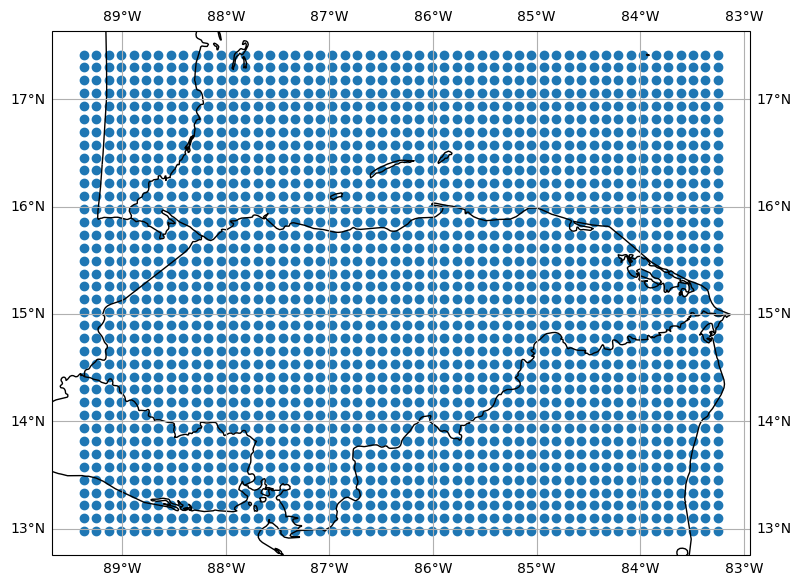

In [ ]:
# from climada.util.api_client import Client
# from climada.hazard import TropCyclone
import climada.util.lines_polys_handler as u_lp
from climada.entity.impact_funcs import ImpactFuncSet
from climada.hazard import (
    Centroids,
    TropCyclone,
    TCTracks,
)  # from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity import ImpfTropCyclone
from climada.entity import Exposures


# haz = Client().get_hazard("storm_europe", name="test_haz_WS_nl", status="test_dataset")


track = TCTracks.from_ibtracs_netcdf(
    provider="usa", storm_id="1998295N12284"
)  # eta: 2020306N15288, mitch: 1998295N12284

# construct centroids
cent_bounds = gdf_roads.geometry.total_bounds
cent = Centroids.from_pnt_bounds(cent_bounds, res=0.12)
cent.plot()

# construct tropical cyclones
haz = TropCyclone.from_tracks(track, centroids=cent)

# exposures
exp_line = Exposures(gdf_roads)

# impact function
impf_line = ImpfTropCyclone.from_emanuel_usa()
impf_set = ImpactFuncSet([impf_line])

exp_line.data["impf_TC"] = 1  # specify impact function

Finally, we use the wrapper function `calc_geom_impact` to compute the impacts in one line of code.
For a reminder, the `calc_geom_impact` is covering the 3 steps of shapes-to-points disagreggation,
impact calculation, and reaggregation to the original shapes. `calc_geom_impact` requires the user
to specify a target resolution of the disaggregation (`res`), as well as how to assign a value
to the disaggregated exposure (`disagg_met` and `disagg_val`). Here, we arbitrarily decide to give a 
fixed value 100k USD to each road segment of 500m, but note that other options are possible.

In [5]:
# disaggregate in the same CRS as the exposures are defined (here meters), resolution 500m
# divide values on points
# aggregate by summing

impact = u_lp.calc_geom_impact(
    exp=exp_line,
    impf_set=impf_set,
    haz=haz,
    res=500,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=1e5,
    agg_met=u_lp.AggMethod.SUM,
);

Finally, let's plot the impact calculated.

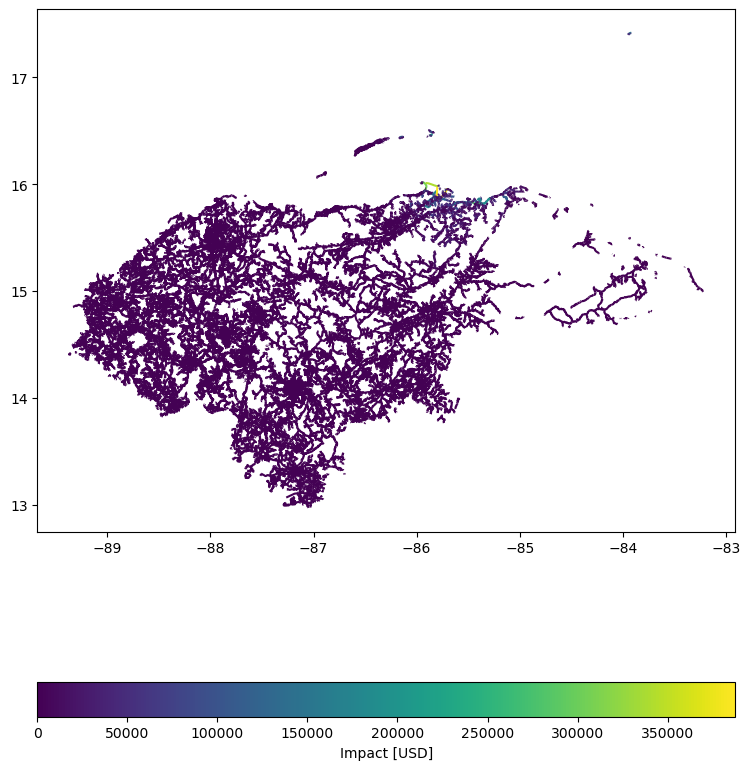

In [6]:
# plot the calculated impacts
u_lp.plot_eai_exp_geom(impact);

## Set-up CLIMADA exposures from OpenStreetMap
Within the CLIMADA plateform, there are two main ways to obtain exposure data from OpenStreetMap:
1. Using the `osm-flex` module directly available from the CLIMADA core environment
2. Using the `OSMApiQuery` methods from the `Exposures.osm_dataloader` module available in CLIMADA petals

In this tutorial, we will only provide a brief introduction to the first method making use of `osm-flex`. 
Please refer to the [documentation](https://climada-petals.readthedocs.io/en/stable/tutorial/climada_exposures_openstreetmap.html) for more detailed explanations on the two methods.

### osm-flex
`osm-flex` is a python package which allows to flexibly extract data from OpenStreetMap.
See [osm-flex](https://osm-flex.readthedocs.io/en/latest/?badge=latest) and the associated publication 
for more information: *Mühlhofer, Kropf, Riedel, Bresch and Koks: OpenStreetMap for Multi-Faceted Climate Risk Assessments. Environ. Res. Commun. **6** 015005 doi: [10.1088/2515-7620/ad15ab](https://iopscience.iop.org/article/10.1088/2515-7620/ad15ab)* 
Obtaining CLIMADA exposures object from OpenStreetMap using `osm-flex` consists in the following 
steps:
1. **Download** a raw osm.pbf file ("data dump") for a specific country or region from geofabrik.de
2. **Extract** the features of interest (e.g. a road network) as a geodataframe
3. **Pre-process**; apply pre-processing steps as e.g. clipping, simplifying, or reprojecting the retrieved layer.
4. **Cast** the geodataframe into a CLIMADA `Exposures` object.
5. **Disagreggate** complex shapes exposures into points for impact calculation.
Once those 5 steps are completed, one can proceed with the impact calculation. For more details on 
how to use lines and polygons as exposures within CLIMADA, please refer to the [documentation](https://climada-python.readthedocs.io/en/latest/tutorial/climada_entity_Exposures_polygons_lines.html).

In the following, we illustrate how to obtain different exposures types such as healthcare facilities,
road networks, or forests and how to use them within CLIMADA as points, lines,
and polygons exposures. We also briefly illustrate the use of the `clip` and `simplify` modules
available within the `osm-flex` package.

#### Download a raw osm.pbf file ("data dump")
First, we need to select a specific country and download its data from geofabrik.de. It is possible to
download data from specific countries using iso3 codes or for regions directly.

In [7]:
# (checks if file honduras-latest.osm.pbf already exists)
# file is stored as defined in osm_flex.config.OSM_DATA_DIR unless specified otherwise
iso3 = "HND"
path_ctr_dump = osm_flex.download.get_country_geofabrik(iso3)

INFO:osm_flex.download:Skip existing file: /Users/lseverino/osm/osm_bpf/honduras-latest.osm.pbf


#### Extract the features of interest

We next extract infrastructure or sector-specific data of interest. 

In [8]:
# check available critical infrastructure types:
osm_flex.config.DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [9]:
# lets extract all healthcares from the Honduras file, via the wrapper
gdf_hc = osm_flex.extract.extract_cis(path_ctr_dump, "healthcare")

INFO:osm_flex.extract:query is finished, lets start the loop


extract points: 100%|██████████| 149/149 [00:00<00:00, 348.69it/s]
INFO:osm_flex.extract:query is finished, lets start the loop
extract multipolygons: 100%|██████████| 330/330 [00:11<00:00, 28.07it/s]


In [10]:
# set crs
gdf_hc = gdf_hc.to_crs(epsg=4326)

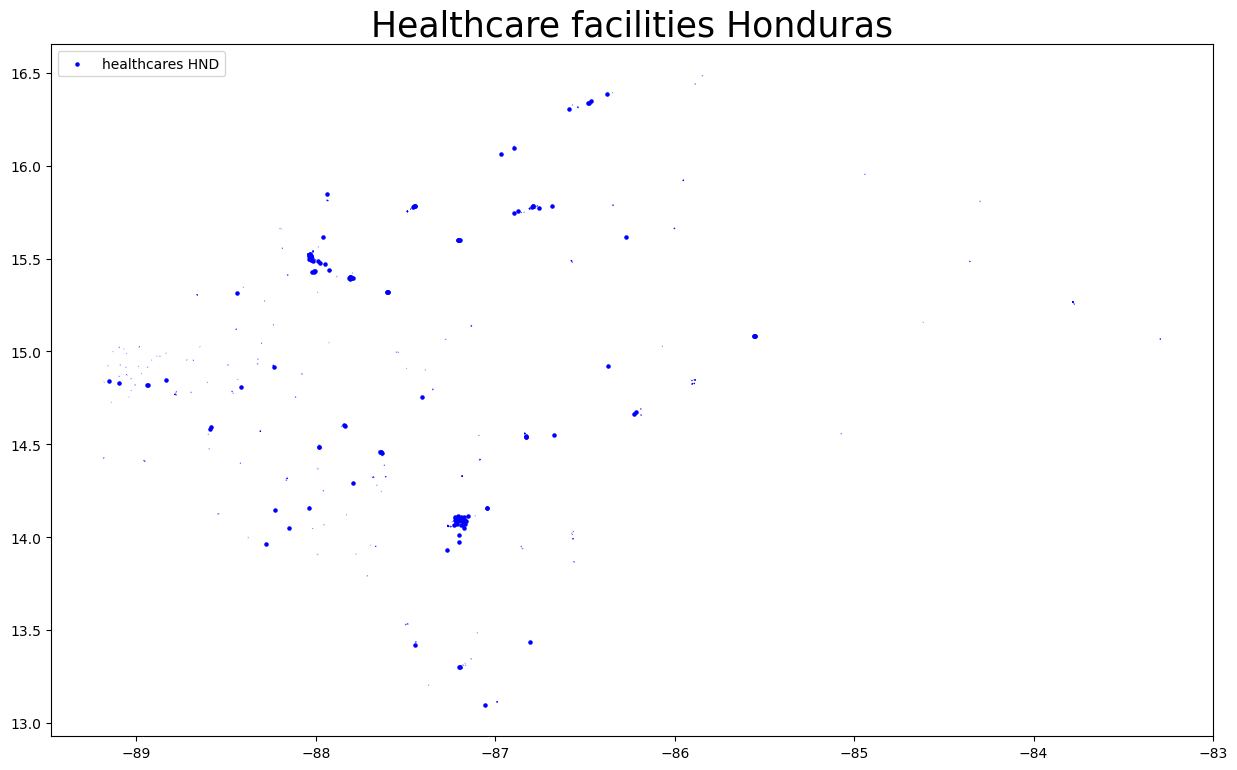

In [11]:
# plot results
ax = gdf_hc.plot(
    figsize=(15, 15),
    alpha=1,
    markersize=5,
    color="blue",
    edgecolor="blue",
    label="healthcares HND",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc="upper left")
ax.set_title("Healthcare facilities Honduras", fontsize=25)
plt.show()

Alternatively, any other tags that are available on openstreetmap can also be queried with the `extract()` method.
Two variables have to be specified: `osm_keys`, a list with all the columns to report in the gdf, and `osm_query`, a string of key-value constraints to apply during the search.

In [12]:
# Forests (multipolygons) in Honduras
osm_keys = ["landuse"]
osm_query = "landuse='forest'"
gdf_forest = osm_flex.extract.extract(
    path_ctr_dump, "multipolygons", osm_keys, osm_query
)

INFO:osm_flex.extract:query is finished, lets start the loop


extract multipolygons: 100%|██████████| 750/750 [00:06<00:00, 122.53it/s]


In [13]:
# set crs
gdf_forest = gdf_forest.to_crs(epsg=4326)

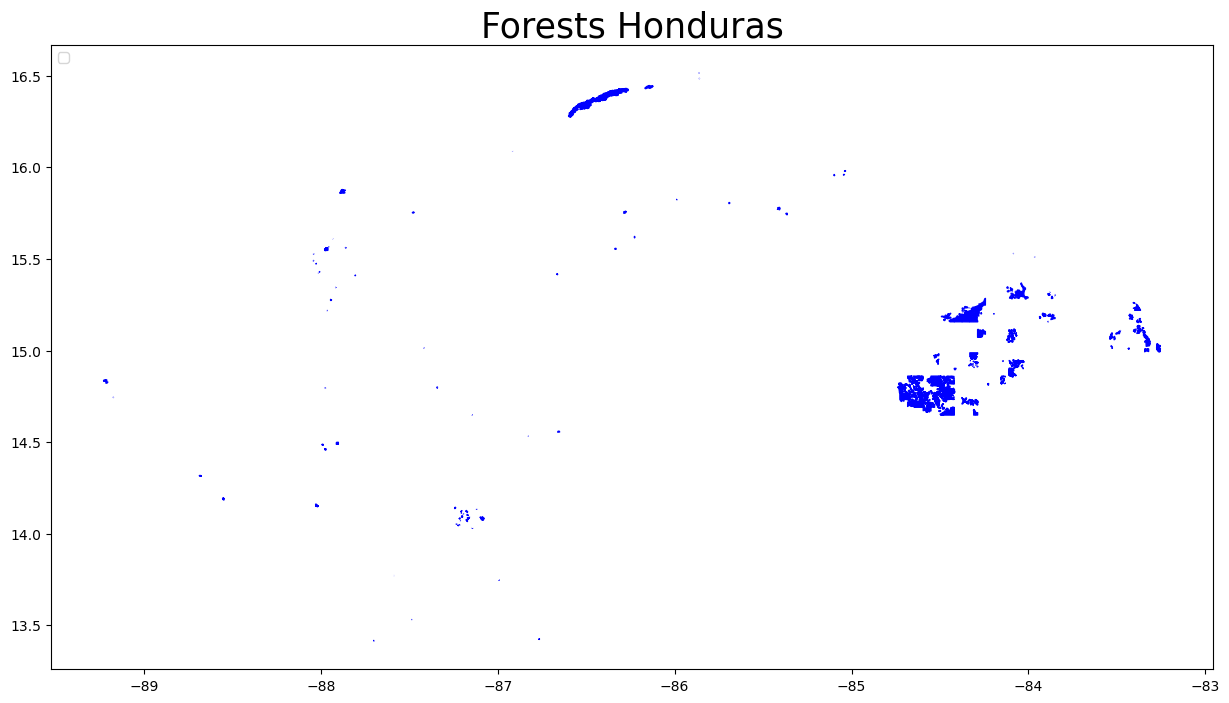

In [14]:
# Plot results
ax = gdf_forest.plot(
    figsize=(15, 15),
    alpha=1,
    markersize=5,
    color="blue",
    edgecolor="blue",
    label="forests HND",
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc="upper left")
ax.set_title("Forests Honduras", fontsize=25)
plt.show()

#### Pre-process the retrieved OSM exposures data (optional)
It can be necessary to apply some preprocessing steps before using the retrieved OSM
data as CLIMADA exposures. In particular, we showcase the following two pre-processing steps:
1. **Clipping**; allows to clip the country data to a user-determined region.
2. **Simplify**; in some cases, simplifying the retrieved data is necessary to remove redundant or erroneous
features that would later affect the impact calculation.

In [15]:
##here we download a region polygon and use it to clip the country file
# import osm_flex.clip as cp
#
## Obtain a region polygon (Francisco Morazan) and clip the country file to it:
# admin_1_hnd = cp.get_admin1_shapes('HND')
# francisco_morazan_shp = list(admin_1_hnd.values())[-1]
# cp.clip_from_shapes([francisco_morazan_shp],
#                    osmpbf_output=osm_flex.config.OSM_DATA_DIR.joinpath('francisco_morazan.osm.pbf'),
#                    osmpbf_clip_from=path_ctr_dump,
#                    kernel='osmosis', overwrite=True)

In [16]:
# here we illustrate how to simplify the polygon-based forest layer by removing small polygons
import osm_flex.simplify as sy

# initial number of points
print(f"Number of results: {len(gdf_forest)}")

gdf_forest = gdf_forest.to_crs("epsg:5456")  # metre-based CRS for Honduras
min_area = 100

gdf_forest = sy.remove_small_polygons(
    gdf_forest, min_area
)  # remove all areas < 100m2 (always in units of respective CRS)
print(f"Number of results after removal of small polygons: {len(gdf_forest)}")

Number of results: 750
Number of results after removal of small polygons: 739


#### Cast OSM exposures into CLIMADA exposures objects
The last step consists in transforming exposures data obtained from OSM into
CLIMADA-readable objects. This is simply done using the CLIMADA `Exposures`class.

In [17]:
from climada.entity import Exposures

gdf_forest = gdf_forest.to_crs(
    epsg=4326
)  # !ensure that all exposures are in the same CRS!
exp_poly = Exposures(gdf_forest)

Additionally, multiple exposures of different types can be combine within a single
CLIMADA `Exposures` object using `concat`.

In [18]:
exp_points = Exposures(gdf_hc)

exp_mix = Exposures.concat([exp_points, exp_line, exp_poly])

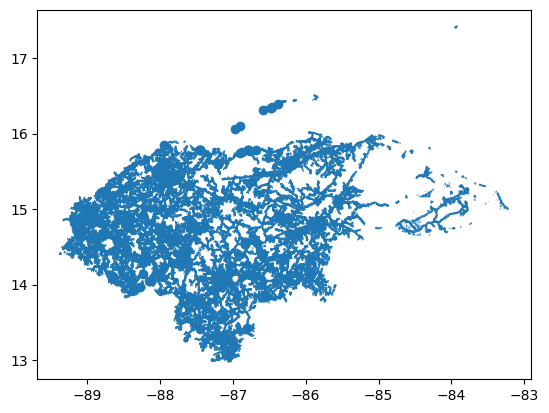

In [19]:
exp_mix.plot()

#### Disagreggate complex shapes into point data
The last step before proceeding to the usual impact calculation consists in transforming 
all the exposure data that is in a format other than point (e.g. lines, polygons) into point data (disagreggation) and assigning them values. Those two tasks can be done simultaneously using the util function `exp_geom_to_pnt`. Disagreggating and assigning values to the disagreggated exposures requires the following:
1. Specify a resolution for the disaggregation (`res`).
2. Specify a value to be disaggregated (`disagg_val`).
3. Specify how to distribute the value to the disaggregated points (`disagg_met`).

In the following, we illustrate how to disaggregate our mixed-types exposures to 
a 10km-resolution, arbitrarily assigning a fixed value of 500k USD to each point. For more details on 
how to use lines and polygons as exposures within CLIMADA, please refer to the [documentation](https://climada-python.readthedocs.io/en/latest/tutorial/climada_entity_Exposures_polygons_lines.html).



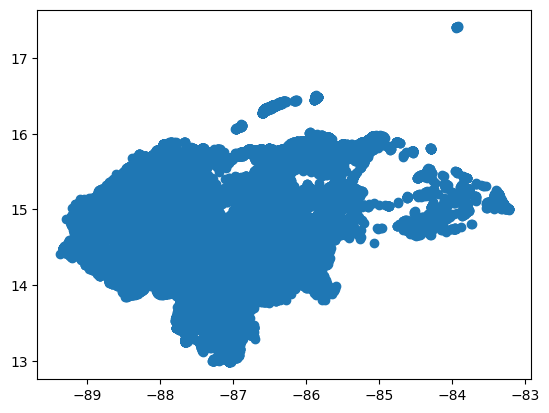

In [22]:
exp_mix_pnt = u_lp.exp_geom_to_pnt(
    exp_mix,
    res=10000,
    to_meters=True,
    disagg_met=u_lp.DisaggMethod.FIX,
    disagg_val=5e5,
)
exp_mix_pnt.plot()